# 第4章 利用用户标签数据

&emsp;&emsp;**标签**是一种无层次化结构的、用来描述信息的关键词，它可以用来描述物品的语义。根据给物品打标签的人的不同，标签应用一般分为两种：一种是让作者或专家给物品打标签；另一种是让普通用户给物品打标签，也就是UGC的标签应用。

## UGC标签系统的代表应用

- Delicious
- CiteULike论文书签网站
- Last.fm音乐网站
- 豆瓣
- Hulu视频网站

标签系统的作用：  
- 表达：标签系统帮助我表达对物品的看法
- 组织：打标签帮助我组织我喜欢的电影
- 学习：打标签帮助我对电影的了解
- 发现：标签系统使我更容易发现喜欢的电影
- 决策：标签系统帮助我判定是否看某一部电影

## 标签系统中的推荐问题

标签系统中的推荐问题主要有以下两个：
- 如何利用用户打标签的行为，为其推荐物品（基于标签的推荐）？
- 如何在用户给物品打标签时，为其推荐适合该物品的标签（标签推荐）？

### 用户为什么进行标注

用户标注的动机：
- 社会维度：给内容上传者使用的（便于上传者组织自己的信息）；给广大用户使用的（便于帮助其他用户找到信息）
- 功能维度：用于更好地组织内容，方便用户将来的查找；传达某种信息，比如照片拍摄的时间和地点 

### 用户如何打标签

In [1]:
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

PROJECT_ROOT = os.path.dirname(sys.path[0])

In [2]:
from main.util import delicious_reader

delicious_path = os.path.join(PROJECT_ROOT, 
                              "src/data/delicious-2k/user_taggedbookmarks-timestamps.dat")

data, _ = delicious_reader.split_data(filename=delicious_path, cv_folder=10, k=20)
len(data)

437593

In [3]:
def tag_popularity(data):
    tags = dict()

    for user_id, bookmark_id, tag_id in data:
        tags[tag_id] = tags.get(tag_id, 0) + 1

    counts = list(tags.values())
    freqs = set(counts)

    tag_counts = dict()

    for freq in freqs:
        tag_counts[freq] = counts.count(freq)
    return tag_counts

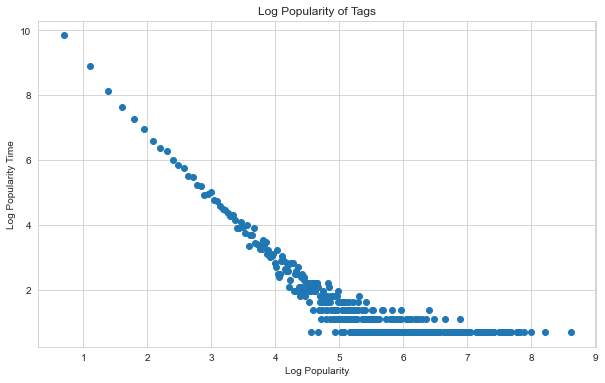

In [4]:
tag_freq = tag_popularity(data)

sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

popularity = np.log1p(list(tag_freq.keys()))
popularity_time = np.log1p(list(tag_freq.values()))

plt.scatter(popularity, popularity_time)
plt.title("Log Popularity of Tags")
plt.xlabel("Log Popularity")
plt.ylabel("Log Popularity Time")

plt.show()

### 用户打什么样的标签

- 表明物品是什么
- 表明物品的种类
- 表明谁拥有物品
- 表达用户的观点
- 用户相关的标签
- 用户的任务

## 基于标签的推荐系统

&emsp;&emsp;一个用户标签行为的数据集一般由一个三元组的集合表示，其中记录$(u,i,b)$表示用户$u$给物品$i$打上了标签$b$。

### 实验设置
多样性：  
&emsp;&emsp;用物品标签向量的余弦相似度度量物品之间的相似度。对于每个物品$i$，item_tag[i]存储了物品$i$的标签向量，其中item_tag[i][b]是对物品$i$打标签$b$的次数，那么物品$i$和$j$的余弦相似度如下：

In [5]:
import math

def cosine_sim(item_tags, i, j):
    ret = 0
    for b, wib in item_tags[i].items():
        if b in item_tags[j].items():
            ret += wib * item_tags[j][b]
    
    n_i = 0
    n_j = 0
    for b, w in item_tags[i].items():
        n_i += w * w
    for b, w in item_tags[j].items():
        n_j += w * w
        
    if ret==0:
        return 0
    return ret / math.sqrt(n_i * n_j)

得到物品之间的相似度度量后，通过下面公式计算一个推荐列表的多样性：$$\text{Diversity} = 1 - \frac{\displaystyle \sum_{i \in R(u)}\sum_{j \in R(u), j \neq i} \text{Sim}(\text{item_tag}[i], \text{item_tag}[j])}{\left\lgroup\begin{array}{c} |R(u)| \\ 2\end{array}\right\rgroup}$$

In [6]:
def diversity(item_tags, recommend_items):
    ret = 0
    n = 0
    for i in recommend_items.keys():
        for j in recommend_items.keys():
            if i == j:
                continue
            ret += cosine_sim(item_tags, i, j)
            n += 1
    
    return ret / (n * 1.0)

推荐结果的新颖性，用推荐结果的平均热门程度（AveragePopularity）度量。对于物品$i$，它的流行度item_pop[i]表示对这个物品打过标签的用户数，平均热门程度的公式如下：$$\text{AveragePopularity}=\frac{\displaystyle \sum_u \sum_{i \in R(u)} \log(1 + \text{item_pop}(i))}{\displaystyle \sum_u \sum_{i \in R(u)} 1}$$

### 一个最简单的算法

该算法描述如下：  
1. 统计每个用户最常用的标签
2. 对于每个标签，统计被打过这个标签次数最多的物品
3. 对于一个用户，首先找到他常用的标签，然后找到具有这些标签的最热门物品，推荐给这个用户

用户$u$对物品$i$的兴趣公式如下：$$p(u,i)=\sum_b n_{u,b} n_{b,j}$$其中，$B(u)$是用户$u$打过的标签集合，$B(i)$是物品$i$被打过的标签集合，$n_{u,b}$是用户$u$打过标签$b$的次数，$n_{b,i}$是物品$i$被打过标签$b$的次数。

In [7]:
origin_train, origin_test = delicious_reader.split_data(
    filename=delicious_path, k=1, cv_folder=10)

print("Len Train : %s, Len Test : %s" % (len(origin_train), len(origin_test)))

Len Train : 397695, Len Test : 39898


In [8]:
from main.chapter4.simple_tag_based import SimpleTagBased

base_model = SimpleTagBased()
base_model.train(origin_train)

In [9]:
test = dict()
for user_id, item_id, tag_id in origin_test:
    test.setdefault(user_id,[])
    test[user_id].append(item_id)

In [10]:
# 找出所有商品ID（用于计算覆盖率）
all_items = set()

for user_id, item_id, tag_id in origin_train:
    all_items.add(item_id)
for user_id, item_id, tag_id in origin_test:
    all_items.add(item_id)

In [11]:
recommend_count = 20

recommend_users = list(test.keys())
recommends = base_model.recommend_users(
                users=recommend_users,
                recommend_count=recommend_count
)

In [12]:
from main.util import metric

simple_tag_based_evals = metric.tag_evaluation(origin_train, test, all_items, recommends)

pd.DataFrame(
        data = [simple_tag_based_evals],
        index = ["SimpleTagBased"],
        columns = ["Precision","Recall","Coverage","Popularity"]
)

,Precision,Recall,Coverage,Popularity
SimpleTagBased,0.00044,0.000396,0.061945,3.764438


### 算法的改进

简单算法公式预测用户$u$对物品$i$的兴趣：$$p(u,i)=\sum_b n_{u,b} n_{b,i}$$这个公式倾向于给热门标签对应的热门物品很大的权重，因此会造成推荐热门的物品给用户，从而降低推荐结果的新颖性。该公式利用用户的标签向量对用户兴趣建模，其中每个标签都是用户使用过的标签，而权重是用户使用该标签的次数，这样就给热门标签过大的权重，导致不能反映用户个性化的兴趣。  

#### TagBasedTFIDF算法
$$p(u,i)=\sum_b \frac{n_{u,b}}{\log(1+n_b^{(u)})}n_{b,i}$$其中，$n_b^{(u)}$记录了标签b被多少个不同的用户使用过。

In [13]:
from main.chapter4.tag_based_tfidf import TagBasedTFIDF

tfidf_model = TagBasedTFIDF()
tfidf_model.train(origin_data=origin_train)

In [14]:
test = dict()
for user_id, item_id, tag_id in origin_test:
    test.setdefault(user_id, [])
    test[user_id].append(item_id)
    
test = {user_id : set(items) for user_id, items in test.items()}

In [15]:
# 找出所有商品（用于计算覆盖率）
all_items = set()

for user_id, item_id, tag_id in origin_train:
    all_items.add(item_id)
for user_id, item_id, tag_id in origin_test:
    all_items.add(item_id)

In [16]:
recommend_count = 20

recommend_users = list(test.keys())
recommends = tfidf_model.recommend_users(
                users=recommend_users,
                recommend_count=recommend_count
)

In [17]:
from main.util import metric

tfidf_evals = metric.tag_evaluation(origin_train, test, all_items, recommends)

pd.DataFrame(
        data = [simple_tag_based_evals, tfidf_evals],
        index = ["SimpleTagBased", "TagBasedTFIDF"],
        columns = ["Precision","Recall","Coverage","Popularity"]
)

,Precision,Recall,Coverage,Popularity
SimpleTagBased,0.000440,0.000396,0.061945,3.764438
TagBasedTFIDF,0.000472,0.000424,0.090317,3.632179


#### TagBasedTFIDF++算法：
$$p(u,i)=\sum_b \frac{n_{u,b}}{\log(1+n_b^{(u)})} \frac{n_{b,i}}{\log(1+n_i^{(u)})}$$其中，$n_i^{(u)}$记录了物品$i$被多少个不同的用户打过标签。

In [18]:
from main.chapter4.tag_based_tfidf_plus import TagBasedTFIDFPlus

tfidf_plus_model = TagBasedTFIDFPlus()
tfidf_plus_model.train(origin_data=origin_train)

In [19]:
test = dict()
for user_id, item_id, tag_id in origin_test:
    test.setdefault(user_id,[])
    test[user_id].append(item_id)
    
test = {user_id : set(items) for user_id, items in test.items()}

In [20]:
# 找出所有商品（用于计算覆盖率）
all_items = set()

for user_id, item_id, tag_id in origin_train:
    all_items.add(item_id)
for user_id, item_id, tag_id in origin_test:
    all_items.add(item_id)

In [21]:
recommend_count = 20

recommend_users = list(test.keys())
recommends = tfidf_plus_model.recommend_users(
                users=recommend_users,
                recommend_count=recommend_count
)

In [22]:
from main.util import metric

tfidf_plus_evals = metric.tag_evaluation(origin_train, test, all_items, recommends)

pd.DataFrame(
        data = [simple_tag_based_evals, tfidf_evals, tfidf_plus_evals],
        index = ["SimpleTagBased", "TagBasedTFIDF", "TagBasedTFIDFPlus"],
        columns = ["Precision","Recall","Coverage","Popularity"]
)

,Precision,Recall,Coverage,Popularity
SimpleTagBased,0.000440,0.000396,0.061945,3.764438
TagBasedTFIDF,0.000472,0.000424,0.090317,3.632179
TagBasedTFIDFPlus,0.000440,0.000396,0.176632,2.767007


#### 数据稀疏性

&emsp;&emsp;对于新用户或者新物品，集合（$B(u) \cap B(i)$）中的标签数量会很少。为了提高推荐的准确率，可能要对标签集合做扩展。  
&emsp;&emsp;标签扩展的本质是对每个标签找到和它相似的标签，也就是计算标签之间的相似度。如果认为同一个物品上的不同标签具有某种相似度，那么当两个标签同时出现在很多物品的标签集合中时，可以认为这两个标签具有较大的相似度。  
对于标签b，令$N(b)$为有标签b的物品的集合，$n_{b,i}$为给物品$i$打上标签$b$的用户数，可以通过余弦相似度公式计算标签$b$和标签$b'$的相似度：$$\text{sim}(b, b')=\frac{\displaystyle \sum_{i \in N(b) \cap N(b') } n_{b,i} n_{b',i}}{\displaystyle \sqrt{\sum_{i \in N(b)} n_{b,i}^2 \sum_{i \in N(b')} n_{b',i}^2}}$$

In [23]:
from main.chapter4.tag_based_tfidf_plus_sim import SimTagTFIDF

sim_tag_tfidf_model = SimTagTFIDF()
sim_tag_tfidf_model.train(origin_train)

In [24]:
similarity_matrix = sim_tag_tfidf_model.tag_vec_report(tops=30)

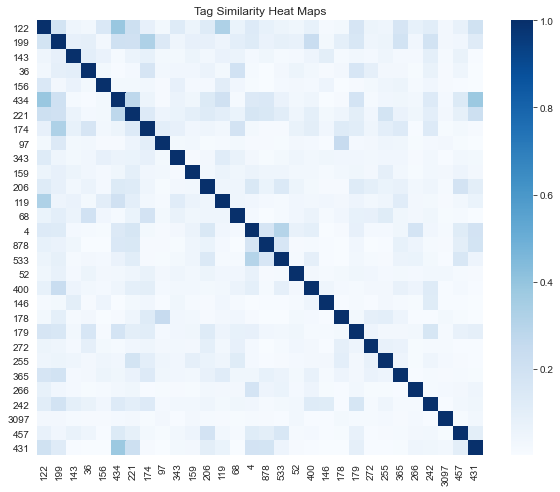

In [25]:
import seaborn as sns
sns.set_style("whitegrid")
plt.figure(figsize=(10,8))

plt.title("Tag Similarity Heat Maps")
plt.xlabel("Tags")
plt.ylabel("Tags")
sns.heatmap(similarity_matrix,cmap=plt.cm.Blues,)

plt.show()

In [26]:
test = dict()
for user_id, item_id, tag_id in origin_test:
    test.setdefault(user_id,[])
    test[user_id].append(item_id)
    
test = {user_id : set(items) for user_id, items in test.items()}

In [27]:
# 找出所有商品（用于计算覆盖率）
all_items = set()

for user_id, item_id, tag_id in origin_train:
    all_items.add(item_id)
for user_id, item_id, tag_id in origin_test:
    all_items.add(item_id)

In [28]:
recommend_count = 20

recommend_users = list(test.keys())
recommends = sim_tag_tfidf_model.recommend_users(
                users=recommend_users,
                recommend_count= recommend_count
)

In [29]:
from main.util import metric

sim_tag_tfidf_evals = metric.tag_evaluation(origin_train, test, all_items, recommends)

pd.DataFrame(
        data = [simple_tag_based_evals, tfidf_evals, tfidf_plus_evals, sim_tag_tfidf_evals],
        index = ["SimpleTagBased", "TagBasedTFIDF", "TagBasedTFIDFPlus", "SimTagTFIDF"],
        columns = ["Precision","Recall","Coverage","Popularity"]
)

,Precision,Recall,Coverage,Popularity
SimpleTagBased,0.000440,0.000396,0.061945,3.764438
TagBasedTFIDF,0.000472,0.000424,0.090317,3.632179
TagBasedTFIDFPlus,0.000440,0.000396,0.176632,2.767007
SimTagTFIDF,0.000440,0.000395,0.177311,2.766880


#### 标签清理

标签清理的原因：会出现词形不同、词义相同的标签，需要将标签作为推荐解释。  
标签清理的方法：
- 去除词频很高的停止词
- 去除因词根不同造成的同义词
- 去除因分隔符造成的同义词

### 基于图的推荐算法

&emsp;&emsp;在用户标签数据集上，有3中不同的元素，即用户、物品和标签，可以定义3种顶点，这是一个用户-物品-标签图。再采用第2章的PersonalRank算法，计算所有物品节点相对于当前用户节点在图上的相关性，然后按照相关性从大到小的排序，给用户推荐排名最高的N个物品。

### 基于标签的推荐解释

以豆瓣的标签云为例：
1. 提供了推荐结果的多样性，展示了用户的所有兴趣，然后让用户自己根据他今天的兴趣选择相关的标签，得到推荐结果，从而极大地提高了推荐结果的多样性。
2. 提供了推荐解释功能，用户通过界面可以知道豆瓣给自己推荐的每一本书，都是基于它认为自己对某个标签感兴趣。

Jesse Vig对基于标签的解释得到的结论：
- 用户对标签的兴趣，对帮助用户理解为什么给他推荐某个物品更有帮助
- 用户对标签的兴趣和物品标签相关度，对于帮助用户判定自己是否喜欢被推荐物品具有同样的作用
- 物品标签相关度，对于帮助用户判定被推荐物品是否符合他当前的兴趣更有帮助
- 客观事实类标签相比主观感受类标签，对用户更有作用

## 给用户推荐标签

### 为什么要给用户推荐标签
- 方便用户输入标签
- 提高标签质量

### 如何给用户推荐标签

用户$u$给物品$i$打标签时，有以下方法给用户推荐和物品$i$相关的标签：  
0. PopularTags算法：给用户$u$推荐整个系统里最热门的标签

In [2]:
def popular_tags(user, item, tags, N):
    return sorted(tags.items(), key=itemgetter(1), reverse=True)[0:N]

1. ItemPopularTags算法：给用户$u$推荐物品$i$上最热门的标签

In [3]:
def item_popular_tags(user, item, item_tags, N):
    return sorted(item_tags[item].items(), key=itemgetter(1), reverse=True)[0:N]

2. UserPopularTags算法：给用户$u$推荐他自己经常使用的标签

In [4]:
def user_popular_tags(user, item, user_tags, N):
    return sorted(user_tags[user].items(), key=itemgetter(1), reverse=True)[0:N]

3. HybridPopularTags算法：融合前面两种算法，通过一个系数将上面的推荐结果线性加权，生成最终的推荐结果。

In [5]:
def hybrid_popular_tags(user, item, user_tags, item_tags, alpha, N):
    max_user_tag_weight = max(user_tags[user].values())
    for tag, weight in user_tags[user].items():
        ret[tag] = (1 - alpha) * weight / max_user_tag_weight
        
    max_item_tag_weight = max(item_tags[item].values())
    for tag, weight in item_tags[item].items():
        if tag not in ret:
            ret[tag] = alpha * weight / max_item_tag_weight
        else:
            ret[tag] += alpha * weight / max_item_tag_weight
    
    return sorted(ret[user].items(), key=itemgetter(1), reverse=True)[0:N]

### 基于图的标签推荐算法

定义顶点的启动概率：$$r_{v(k)}=\left\{ 
\begin{array}{c} 
\alpha(v(k)=v(u)) \\
1 - \alpha(v(k) = v(i)) \\
0 \quad (\text{其他})
\end{array} \right.$$只有用户$u$和物品$i$对应的顶点有非0的启动概率，而其他顶点的启动概率都为0。